# Amazon_Fine_Food_Mini_Project

## Chenglu Xia | Jingwen Zhong

### Import dataset

In [18]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

files_dir = "C:/Users/Jingwen/Desktop/amazon_mini_project" 
os.chdir(files_dir)

In [2]:
df = pd.read_csv("amazon_reviews.csv")

In [5]:
## check up Nulls
df.isnull().any(axis=0)

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

In [6]:
df.isnull().sum(axis=0)

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
df.fillna("", inplace=True) ##fill up NAs

# Part 1

### a)

In [6]:
df['Text_length'] = df['Text'].apply(lambda x:len(x))
df['Summary_length'] = df['Summary'].apply(lambda x: len(x))
df['Helpfulness_ratio'] = df.apply(lambda x:x['HelpfulnessNumerator']/x['HelpfulnessDenominator'] if x['HelpfulnessDenominator'] !=0 else 0, axis=1)

In [7]:
df[['Text_length','Summary_length','Score','Helpfulness_ratio']].describe().T[['min','mean','50%','max']]

,min,mean,50%,max
Text_length,12.0,436.222083,302.0,21409.0
Summary_length,0.0,23.445744,20.0,128.0
Score,1.0,4.183199,5.0,5.0
Helpfulness_ratio,0.0,0.407862,0.0,3.0


### b)

In [8]:
df2 = df.copy()

In [9]:
import time
df2['Time'] = df2['Time'].apply(lambda x:time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(x)))

df2['Time'] = pd.to_datetime(df2['Time'])

In [10]:
df2["Date"] = df2['Time'].dt.date
df2["Year"] = df2['Time'].dt.year
df2["Month"] = df2['Time'].dt.month
df2["Day"] = df2['Time'].dt.day
df2["Hour"] = df2['Time'].dt.hour

In [11]:
df2 = df2.groupby(['Year', 'Month', 'Day']).sum()
df2 = df2.reset_index()
del df2['Hour']

In [12]:
df2['Date'] = pd.PeriodIndex(year = df2['Year'], month = df2['Month'],day = df2['Day'],
                            freq = 'D')
df2['Date'] = df2['Date'].map(lambda x: x.to_timestamp())
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Date'] = df2['Date'].dt.date

In [13]:
a = [i for i,v in df2['Text_length'].items() if (v>600000)]
a

[2475]

In [14]:
df2 =df2.drop(index =2475 , axis=0, inplace=False)

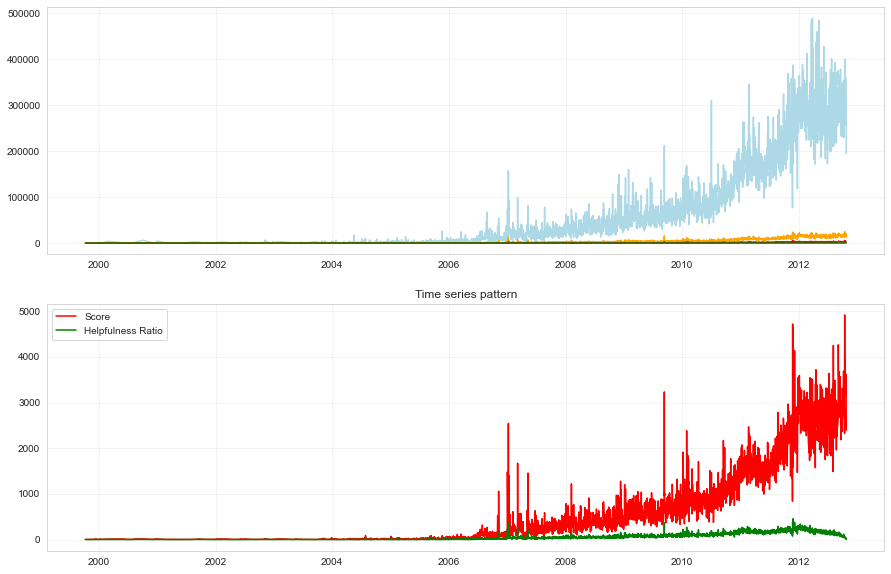

In [15]:
fig, ax = plt.subplots(2,1,figsize = (15,10))
plt.title('Time series pattern')


ax[0].plot(df2['Date'], df2['Text_length'],'-',markersize=2, label='Text Length', color = 'lightblue')
ax[0].plot(df2['Date'], df2['Summary_length'],'-',markersize=2, label='Summary Length',color = 'Orange')
ax[0].plot(df2['Date'], df2['Score'],'-',markersize=2, label='Score', color = 'Red')
ax[0].plot(df2['Date'], df2['Helpfulness_ratio'],'-',markersize=2, label='Helpfulness Ratio',color = 'Green')

ax[0].grid(color = 'grey', alpha =0.1)

ax[1].plot(df2['Date'], df2['Score'],'-',markersize=2, label='Score',color = 'Red')
ax[1].plot(df2['Date'], df2['Helpfulness_ratio'],'-',markersize=2, label='Helpfulness Ratio', color = 'Green')
ax[1].grid(color = 'grey', alpha =0.1)

plt.legend()
plt.show() 
# show plot in python
    # save plot in current file dir
#fig.savefig('Zone%s_Solar_Data_Hourly_General_Behavior'%(Zone_name), bbox_inches="tight")

### c)

In [16]:
# Load the regular expression library
import re
# Remove punctuation
df3 = df.copy()
df3['Text2'] = df3['Text'].map(lambda x:re.sub('[,\.!?]', '', x))
df3['Text2'] = df3['Text2'].map(lambda x:re.sub('br /', '', x))
df3['Text2'] = df3['Text2'].map(lambda x:re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
# Convert the titles to lowercase
df3['Text2'] = df3['Text2'].map(lambda x: x.lower())  
# Print out the first rows of papers
df3['Text2'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price  there was a wide...
Name: Text2, dtype: object

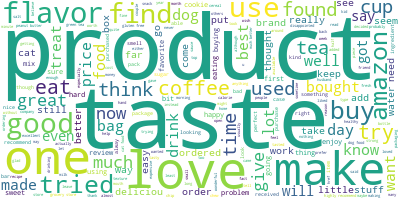

In [17]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df3['Text2'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000,contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [18]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df3['Text2'])

In [19]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words -1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
like taste just good flavor chocolate use great product oil

Topic #1:
great good like love taste just amazon product snack flavor

Topic #2:
tea like taste flavor drink water good sugar just great

Topic #3:
coffee cup like good amazon product price great flavor just

Topic #4:
food dog dogs cat treats like product just cats eat


# d)

Extracting tf-idf features for NMF...


C:\Users\Jingwen\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
C:\Users\Jingwen\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


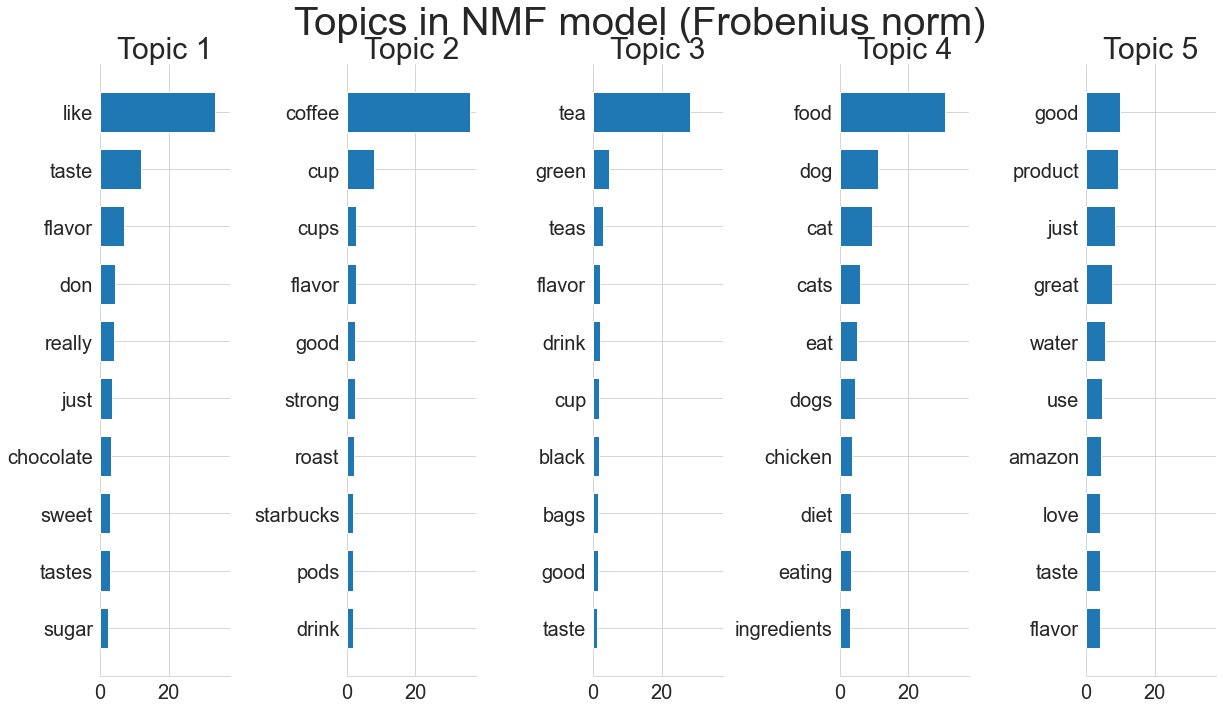

C:\Users\Jingwen\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


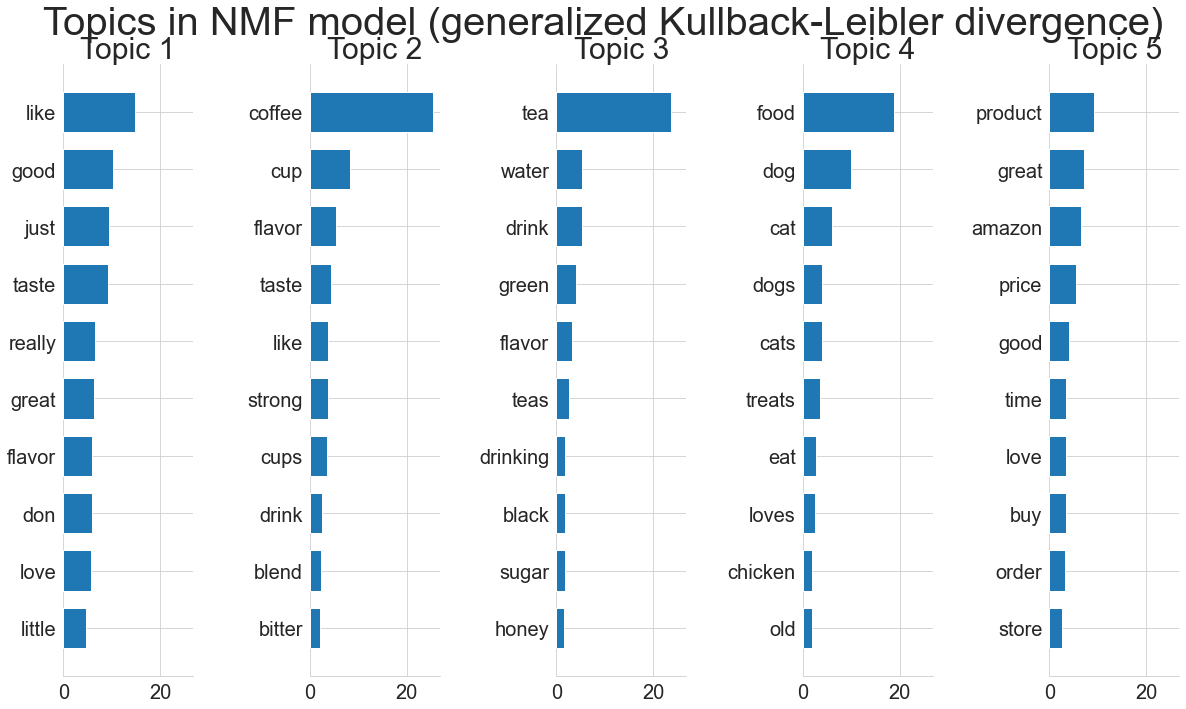

In [20]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 5
n_top_words = 10

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# # Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#t0 = time()
tfidf = tfidf_vectorizer.fit_transform(df3['Text2'])
#print("done in %0.3fs." % (time() - t0))


# Fit the NMF model
#t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(count_data)
#print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')


# Fit the NMF model
#t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(count_data)
#print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')


# e)

###### text cleaning

In [21]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet


lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

In [22]:
from nltk.corpus import stopwords
import string
stops_words = set(stopwords.words("english"))

def tweet_cleaner(text):
    
    text = text.lower()  # lower all letters
        
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE) #Removing HTML tags
    text = re.sub(r'\<a href', ' ', text) # Removing href
    text = re.sub(r'&amp;', '', text) # Removing amp
    text = re.sub(r'<br />', ' ', text)   # Removing br
    text = re.sub("\S*\d\S*", "", text).strip()     # removing the words with numeric digits
    text = re.sub(r"[^a-zA-Z0-9]"," ", text) # Removing punct and emojis
    text = re.sub(r"cfh"," ", text) # Removing cfh/CFH
        
    text = text.split()
    
    text = [w for w in text if not w in stops_words] #remove stopwords

    for w in text[::-1]:
        if len(w)<3:
            text.remove(w)
            
    text_final = ' '.join(text)
    
    # convert contractions
    #for i in stops_not_list:
    #    text_final = re.sub(r"%s"%i, "not", text_final)
        
    return text_final

In [23]:
def lemmatize_tweet(tweet):
    
    #tokenize the tweet and find the POS tag for each token
    
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

In [24]:
tweets = "≧◔◡◔≦text, cups, cup, babe, not, don't"

In [25]:
lemmatize_tweet(tweets)

'text cup cup babe'

In [26]:
df['Summary_clean'] = df['Summary'].apply(lambda x:lemmatize_tweet(x))

In [27]:
df['Text_clean'] = df['Text'].apply(lambda x:lemmatize_tweet(x))

In [28]:
#df.to_csv(r'amazon_reviews2.csv', index = False)

###### get cosine similarity

In [29]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    if type(text)==float:
        pass
    else:
        words = WORD.findall(text)
    return Counter(words)


In [30]:
df['Cosine_score'] = df.apply(lambda x:get_cosine(text_to_vector(x['Text_clean']), text_to_vector(x['Summary_clean'])), axis=1)

C:\Users\Jingwen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


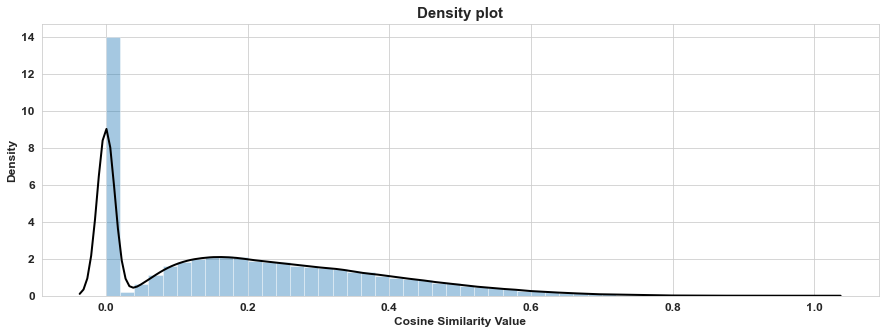

In [31]:
plt.subplots(1,1, figsize=(15,5))

sns.distplot(df['Cosine_score'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Cosine Similarity Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot", fontsize=15, fontweight='bold')

plt.show()

In [20]:
np.mean(df_model['Cosine_score'])

0.19463022604191796

# Part 2

### Data Preprocessing

In [9]:
df_model = df[['Id','Score','Time', 'Text_length', 'Summary_length', 'Helpfulness_ratio', 'Cosine_score']]

###### sentiment analysis and adding more features

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [11]:
df_model['Summary_sentiment'] = df['Summary'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [12]:
df_model['Text_sentiment'] = df['Text'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [13]:
df['Summary_sentiment'] = df_model['Summary_sentiment']
df['Text_sentiment'] = df_model['Text_sentiment']

In [14]:
df_model['Sum_pos_punc'] = df.apply(lambda x:1 if x['Summary'].count("!")>0 and x['Summary_sentiment']>0 else 0, axis =1)

df_model['Sum_neg_punc'] = df.apply(lambda x:1 if x['Summary'].count("!")>0 and x['Summary_sentiment']<0 else 0, axis =1)

df_model['Summary_smile'] = df.apply(lambda x:1 if x['Summary'].count(":) ")>0 and x['Summary_sentiment']>0 else 0, axis =1)

df_model['Summary_sad'] = df.apply(lambda x:1 if x['Summary'].count(":( ")>0 and x['Summary_sentiment']<0 else 0,axis =1)

In [15]:
df_model['Summary_neu'] =  df['Summary'].apply(lambda x:1 if sia.polarity_scores(x)['neu']>0.5 else 0)
df_model['Text_neu'] =  df['Text'].apply(lambda x:1 if sia.polarity_scores(x)['neu']>0.5 else 0)

In [76]:
# df_model['Text_sentiment2'] = df_model.apply(lambda x:0 if x['Cosine_score']==0 and abs(x['Summary_sentiment'])>abs(x['Text_sentiment']) else x['Text_sentiment'],axis =1)
# df_model['Summary_sentiment2'] = df_model.apply(lambda x:0 if x['Cosine_score']==0 and abs(x['Summary_sentiment'])<abs(x['Text_sentiment']) else x['Summary_sentiment'],axis =1)

In [17]:
df_model['Cosine_match'] = df_model.apply(lambda x:1 if x['Cosine_score']==0 else 0,axis =1)

In [18]:
df_model['Sum_punc'] = df['Summary'].apply(lambda x:x.count("!"))
df_model['Text_punc'] = df['Text'].apply(lambda x:x.count("!"))

In [19]:
df_model['Text_pos_punc'] = df.apply(lambda x:1 if x['Text'].count("!")>0 and x['Text_sentiment']>0 else 0, axis =1)

df_model['Text_neg_punc'] = df.apply(lambda x:1 if x['Text'].count("!")>0 and x['Text_sentiment']<0 else 0, axis =1)

df_model['Text_smile'] = df.apply(lambda x:1 if x['Text'].count(":) ")>0 and x['Text_sentiment']>0 else 0, axis =1)

df_model['Text_sad'] = df.apply(lambda x:1 if x['Text'].count(":( ")>0 and x['Text_sentiment']<0 else 0,axis =1)

###### Clean Outliers - not used

In [3]:
df_model = pd.read_csv("amazon_reviews2.csv")
df_model.fillna("", inplace=True) ##fill up NAs

In [20]:
#df_model['Id'] = df['Id']
#df_model.to_csv(r'amazon_reviews2.csv', index = False)

In [15]:
# df_model_clean = df_model.copy()
# df_model_clean.index = df_model_clean['Id']

In [16]:
# plt.subplots(1,1, figsize=(15,5))
# sns.boxplot(y='Text_sentiment', x='Score',data=df_model_clean)
# plt.xticks(rotation=90)
# plt.ylabel('Text_sentiment')
# plt.show()

In [43]:
# from scipy import stats

# for i in range(1,6):
#     outliers = df_model_clean[df_model_clean['Score']==i]['Text_sentiment']
#     z = np.abs(stats.zscore(outliers))
#     df_should_clean = df_model_clean[df_model_clean['Score']==i]
#     df_should_clean['Z_score'] = z
#     ID_clean = df_should_clean[df_should_clean['Z_score']>2.58]['Id'].to_list()
#     df_model_clean = df_model_clean.drop(index = ID_clean , axis=0, inplace=False)

In [44]:
# plt.subplots(1,1, figsize=(15,5))
# sns.boxplot(y='Text_sentiment', x='Score',data=df_model_clean)
# plt.xticks(rotation=90)
# plt.ylabel('Text_sentiment')
# plt.show()

In [45]:
# plt.subplots(1,1, figsize=(15,5))
# sns.boxplot(y='Summary_sentiment', x='Score',data=df_model_clean)
# plt.xticks(rotation=90)
# plt.ylabel('Text_sentiment')
# plt.show()

In [46]:
# from scipy import stats

# for i in range(1,6):
#     outliers = df_model_clean[df_model_clean['Score']==i]['Summary_sentiment']
#     z = np.abs(stats.zscore(outliers))
#     df_should_clean = df_model_clean[df_model_clean['Score']==i]
#     df_should_clean['Z_score'] = z
#     ID_clean = df_should_clean[df_should_clean['Z_score']>2.58]['Id'].to_list()
#     df_model_clean = df_model_clean.drop(index = ID_clean , axis=0, inplace=False)

In [47]:
# plt.subplots(1,1, figsize=(15,5))
# sns.boxplot(y='Summary_sentiment', x='Score',data=df_model_clean)
# plt.xticks(rotation=90)
# plt.ylabel('Text_sentiment')
# plt.show()

###### Oversampling - No use

In [5]:
X = df_model[['Time', 'Text_length', 'Summary_length', 'Helpfulness_ratio', 'Cosine_score',
                'Summary_sentiment','Text_sentiment','Cosine_match',
                'Sum_pos_punc','Sum_neg_punc','Summary_smile','Summary_sad',
                'Text_pos_punc','Text_neg_punc','Text_smile','Text_sad','Sum_punc','Text_punc','Summary_neu','Text_neu']]

y = df_model['Score']

In [6]:
# from imblearn.over_sampling import RandomOverSampler,SMOTE, SVMSMOTE

In [153]:
# from collections import Counter
# from imblearn.over_sampling import RandomOverSampler 
# print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({5: 363122, 4: 80655, 1: 52268, 3: 42640, 2: 29769})


In [ ]:
# ros = SVMSMOTE(sampling_strategy = {5:363122,4:100000,1:80000,3:60000,2:40000}, random_state= 42)
# X_res, y_res = ros.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

In [ ]:
# df_model_res = X_res.copy()
# df_model_res['Score'] = y_res

###### correlation heatmap

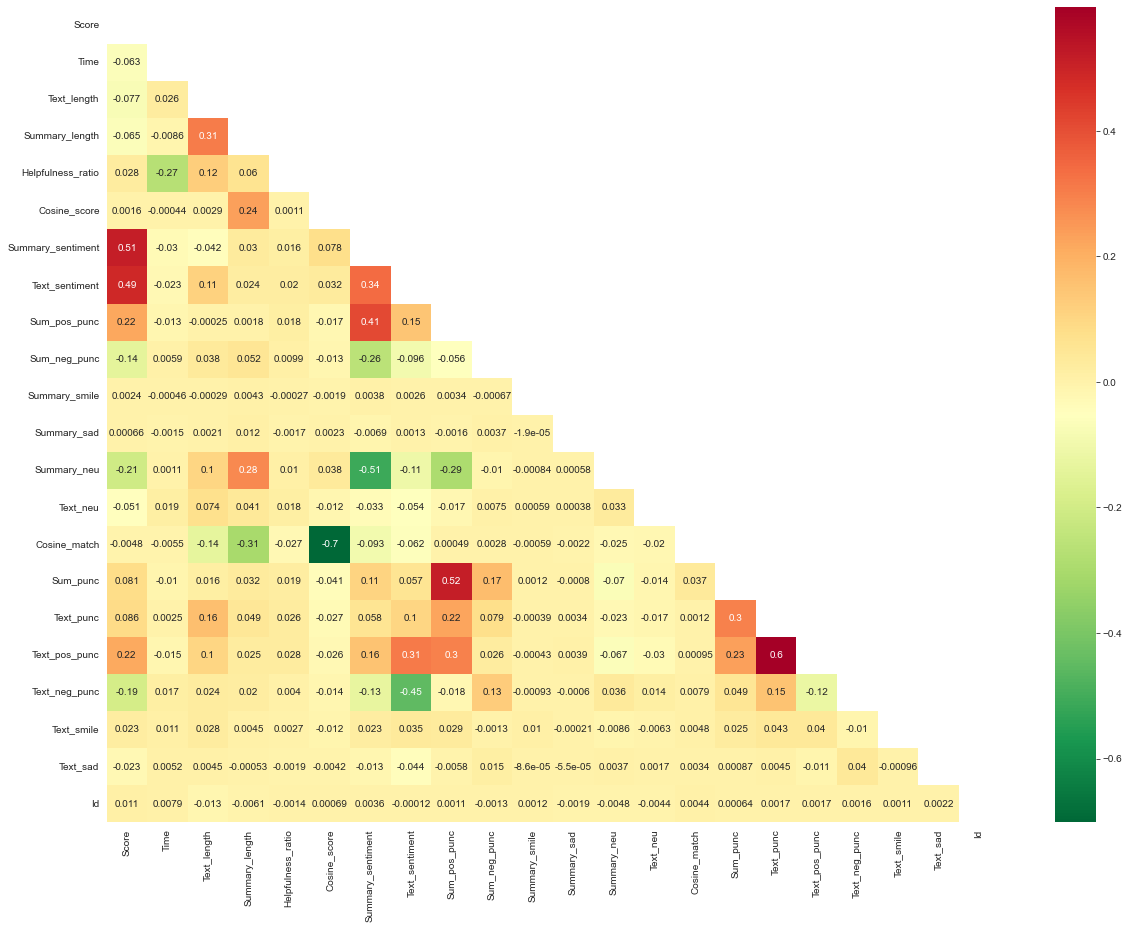

In [21]:


#setting:
plt.figure(figsize=(20,15))

#plot:
correlation_mat = df_model.corr()
upp_mat = np.triu(correlation_mat)
sns.heatmap(correlation_mat, annot = True, cmap="RdYlGn_r",mask = upp_mat)


plt.show()

# Modeling

###### define RMSE function

In [7]:
def modify_pred(y_pred):
    if y_pred > 5:
        return 5
    elif y_pred <1:
        return 1
    else:
        return y_pred

def RMSE_func(predictions, targets):
    predictions = np.array(round(pd.Series(predictions)))
    predictions = pd.Series(predictions)
    predictions = predictions.apply(lambda x:modify_pred(x))
    predictions = np.array(predictions)
            
    targets = np.array(list(targets))
    rmse = np.sqrt(((predictions - targets) ** 2).mean())
    return predictions, rmse

In [8]:
Sample_submission = pd.read_csv("sampleSubmission.csv")

final_result = pd.merge(df_model, Sample_submission, on = ['Id'])

X_test = final_result[['Time', 'Text_length', 'Summary_length', 'Helpfulness_ratio', 'Cosine_score',
                       'Summary_sentiment','Text_sentiment','Cosine_match',
                       'Sum_pos_punc','Sum_neg_punc','Summary_smile','Summary_sad',
                       'Text_pos_punc','Text_neg_punc','Text_smile','Text_sad',
                       'Sum_punc','Text_punc', 'Summary_neu','Text_neu']]

y_test = final_result['Score']


def output(model):
    
    y_pred = model.predict(X_test)
    
    y_pred, RMSE = RMSE_func(y_pred, final_result['Score'])
    final_result['Predicted'] = y_pred
    
    print(RMSE)
    
    final_result1 = final_result[['Id','Predicted']]
    
    return final_result1

## Linear Regression

In [9]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
formula = "Score ~ Text_sentiment*Summary_sentiment + Cosine_match + Text_pos_punc + Text_neg_punc+ Text_smile + Text_sad+ Sum_pos_punc + Sum_neg_punc + Summary_smile +Summary_sad + Time + Text_length  + Summary_length + Helpfulness_ratio+ Cosine_score + Sum_punc +Text_punc +Summary_neu + Text_neu"
ols_model = smf.ols(formula, data = df_model).fit()

In [10]:
# ols_model.summary2()

In [11]:
y_pred_ols = ols_model.predict(X)

In [12]:
y_pred_ols, rmse = RMSE_func(y_pred_ols, y)
rmse

1.0459372531616433

In [13]:
final_result1 =  output(ols_model)

1.0492473492937686


In [14]:
final_result1.to_csv(r'Submission_CJ.csv', index = False)

###### trying weighted linear regression - no use

In [ ]:
# w1 = df_model['Score'].to_list().count(1)
# w2 = df_model['Score'].to_list().count(2)
# w3 = df_model['Score'].to_list().count(3)
# w4 = df_model['Score'].to_list().count(4)
# w5 = df_model['Score'].to_list().count(5)
# list_a = [w1,w2,w3,w4,w5]

# n = len(df_model2)
# df_model2['Weight'] = df['Score'].apply(lambda x: list_a[-x+1]/n)

# # The weighted model
# sample_weight = df_model2['Weight'].values
# regr = LinearRegression()
# regr.fit(X, y, sample_weight)
# y_pred = regr.predict(X)

# y_pred, rmse = RMSE_func(y_pred, df_model['Score'])

# final_result = pd.DataFrame(columns = ['Id', 'Predicted'])
# final_result['Id'] = df_model2['Id']
# final_result['Predicted'] = y_pred
# final_result['Target'] = df['Score']
# final_result.index = df['Id']

# final_result = final_result.iloc[ID]
# ID2 = final_result['Id'].values
# ID2 = ID2-1
# final_result['Id'] = ID2

# final_result['err'] =  abs(final_result["Predicted"]- final_result["Target"])

# sqr_error = final_result['err']**2
# RMSE = np.sqrt(np.mean(sqr_error)) #RMSE
# RMSE

## Ridge 

###### GridSearchCV 

In [15]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# define model
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize
print('RMSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

RMSE: -1.016
Config: {'alpha': 0.30000000000000004}


C:\Users\Jingwen\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.55941e-21): result may not be accurate.
  overwrite_a=True).T


In [16]:
model_ridge = Ridge(alpha= 0.3)

# fit model
model_ridge.fit(X, y)

y_pred_ridge = model_ridge.predict(X)

y_pred_ridge, rmse = RMSE_func(y_pred_ridge, y)

print(rmse)

C:\Users\Jingwen\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.55941e-21): result may not be accurate.
  overwrite_a=True).T


1.0540795731073174


In [17]:
final_result1 =  output(model_ridge)
#final_result1.to_csv(r'Submission_CJ.csv', index = False)

1.056120258303949


# Confusion metrix

In [30]:
y_actual = pd.Series(list(y), name = 'Actual')

y_pred = pd.Series(list(y_pred_ols), name = 'Prediction')

df_confusion = pd.crosstab(y_actual, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


In [33]:
df_confusion

Predicted,1.0,2.0,3.0,4.0,5.0,All
Actual,,,,,,
1,7091,10444,18121,15260,1352,52268
2,1813,4135,10001,12368,1452,29769
3,842,2740,10563,23043,5452,42640
4,234,1252,6775,40539,31855,80655
5,354,1796,13498,133103,214371,363122
All,10334,20367,58958,224313,254482,568454


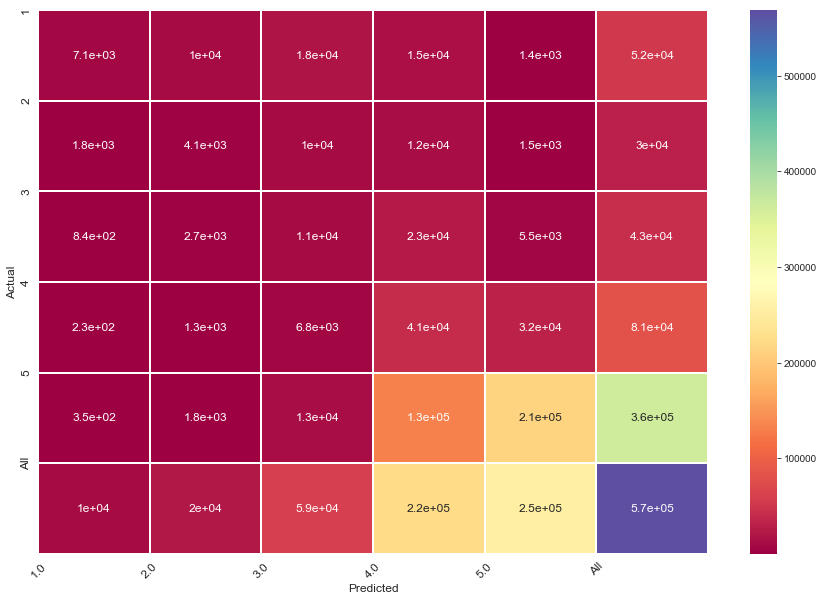

In [41]:
plt.figure(figsize=(15,10))
sns.heatmap(df_confusion, cmap='Spectral', annot = True,annot_kws={"size":12}, linewidths=0.1) # imshow
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45,fontsize=12)
plt.yticks(tick_marks, df_confusion.index,fontsize=12)
#plt.tight_layout()
plt.ylabel(df_confusion.index.name,fontsize=12)
plt.xlabel(df_confusion.columns.name,fontsize=12)
plt.show()